In [3]:
import os
import sys
import time
import csv
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import scipy as sc
import pandas as pd

import aav.modeling as modeling
import assay
import aav.data_prep as data_prep
from sklearn.model_selection import train_test_split
import util

import aav.entropy_opt as entropy_opt
import aav.opt_analysis as opt_analysis

from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 16

import seaborn as sns
sns.set_style('darkgrid')

In [4]:
reload(data_prep)
data_df = data_prep.load_data('old_nnk', use_filtered=False)
seqs, en_scores = data_prep.prepare_data(data_df)

In [5]:
np.max(en_scores[:, 0]), np.min(en_scores[:, 0])

(8.861490846949616, -7.317360523113867)

0.11667107047415005


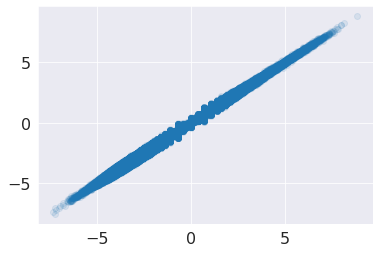

In [7]:
seed = 1234
scale = 0.1

np.random.seed(seed)
score_n = np.random.normal(loc=en_scores[:, 0], scale=scale * np.sqrt(en_scores[:, 1]))

# save before changing en_scores
np.savez('../aav/data_prep_plus_noise_scale{}.npz'.format(scale),
         seqs=seqs, en_scores=en_scores, score_n=score_n)
plt.scatter(en_scores[:, 0], score_n, alpha=0.1);
print(np.sqrt(np.mean(np.square(en_scores[:, 0] - score_n))))

In [8]:
# change en_scores
en_scores[:, 0] = score_n

In [9]:
# define train, cal, and test indices
n_seq = data_df.shape[0]
n_test = 900000
n_cal = 100000

np.random.seed(5678)
shuffle_idx = np.random.permutation(n_seq)
train_idx, test_idx = shuffle_idx[: -n_test], shuffle_idx[-n_test :]
train_idx, cal_idx = train_idx[: -n_cal], train_idx[-n_cal :]
print(train_idx.size, cal_idx.size, test_idx.size)

7552729 100000 900000


In [14]:
# try training ensemble to improve predictions
epochs = 10
batch_size = 64
hidden_size = 100
weighted_loss = True
n_model = 3
savefile = "h%s" % (hidden_size)

enc = data_prep.one_hot_encode
input_shape = data_prep.get_example_encoding(enc).shape
train_gen = assay.DataGenerator(seqs, en_scores, train_idx, batch_size=batch_size, shuffle=True)
test_gen = assay.DataGenerator(seqs, en_scores, test_idx, batch_size=1000, shuffle=False)

for i in range(n_model):
    t0 = time.time()
    model = modeling.make_ann_model(input_shape, num_hid=2, hid_size=hidden_size, weighted_loss=weighted_loss)
    history_callback = model.fit_generator(
        generator=train_gen, epochs=epochs, use_multiprocessing=False, workers=40, verbose=1
    )
    model.save('../aav/models/{}_scale{}_{}_052722.npy'.format(savefile, scale, i))
    print("{} seconds\n\n".format(time.time() - t0))

Epoch 1/10
118011/118011 [==============================] - 1462s 12ms/step - loss: 1.0372
Epoch 2/10
118011/118011 [==============================] - 1461s 12ms/step - loss: 1.0152
Epoch 3/10
118011/118011 [==============================] - 1466s 12ms/step - loss: 1.0066
Epoch 4/10
118011/118011 [==============================] - 1463s 12ms/step - loss: 1.0033
Epoch 5/10
118011/118011 [==============================] - 1464s 12ms/step - loss: 1.0112
Epoch 6/10
118011/118011 [==============================] - 1464s 12ms/step - loss: 1.0109
Epoch 7/10
118011/118011 [==============================] - 1465s 12ms/step - loss: 1.0023
Epoch 8/10
118011/118011 [==============================] - 1463s 12ms/step - loss: 1.0092
Epoch 9/10
118011/118011 [==============================] - 1452s 12ms/step - loss: 1.0014
Epoch 10/10
118011/118011 [==============================] - 1415s 12ms/step - loss: 1.0091
14574.069647789001 seconds


Epoch 1/10
 31192/118011 [======>.......................] - 

KeyboardInterrupt: 

In [12]:
# train more epochs
epochs = 2
batch_size = 64
hidden_size = 100
weighted_loss = True
n_model = 3
savefile = "h%s" % (hidden_size)

enc = data_prep.one_hot_encode
input_shape = data_prep.get_example_encoding(enc).shape
train_gen = assay.DataGenerator(seqs, en_scores, train_idx, batch_size=batch_size, shuffle=True)
test_gen = assay.DataGenerator(seqs, en_scores, test_idx, batch_size=1000, shuffle=False)
    
for i in range(n_model):
    t0 = time.time()
    model = keras.models.load_model('../aav/models/{}_scale{}_{}_052522.npy'.format(savefile, scale, i))
    history_callback = model.fit_generator(
        generator=train_gen, epochs=epochs, use_multiprocessing=False, workers=40, verbose=1
    )
    model.save('../aav/models/{}_scale{}_{}_052522_final.npy'.format(savefile, scale, i))
    print("{} seconds\n\n".format(time.time() - t0))

Epoch 1/2
118011/118011 [==============================] - 1319s 11ms/step - loss: 0.9846
Epoch 2/2
118011/118011 [==============================] - 1312s 11ms/step - loss: 0.9992
2631.555435657501 seconds


Epoch 1/2
118011/118011 [==============================] - 1468s 12ms/step - loss: 1.0011
Epoch 2/2
118011/118011 [==============================] - 1470s 12ms/step - loss: 1.0045
2939.394452571869 seconds


Epoch 1/2
118011/118011 [==============================] - 1460s 12ms/step - loss: 0.9978
Epoch 2/2
118011/118011 [==============================] - 1462s 12ms/step - loss: 1.0032
2922.61603307724 seconds




900/900 - 7s
900/900 - 7s
900/900 - 9s


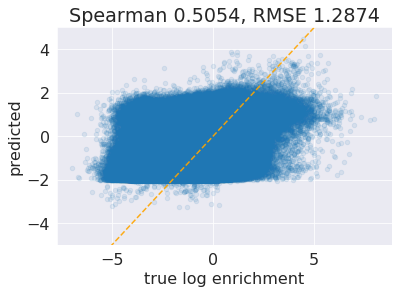

In [42]:
# prediction as mean of ensemble
n_model = 3
pred_sxn = np.zeros([n_model, n_test])
for i in range(n_model):
    model = keras.models.load_model('../aav/models/h100_{}.npy'.format(i))
    pred_sxn[i, :] = model.predict_generator(test_gen, verbose=2).flatten()

pred_n = np.mean(pred_sxn, axis=0)
ytest_n = en_scores[np.array(test_idx[: n_test]), 0]

plt.scatter(ytest_n, pred_n, alpha=0.1, s=20);
util.plot_xy(ytest_n, pred_n)
rho, p = sc.stats.spearmanr(ytest_n, pred_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - pred_n)))

plt.ylim([-5, 5]);
plt.title('Spearman {:.4f}, RMSE {:.4f}'.format(rho, rmse));
plt.xlabel('true log enrichment'); plt.ylabel('predicted');

In [ ]:
test_and_cal_idx = np.hstack([test_idx, cal_idx])
np.savez('../aav/test_and_calibration_data_scale{}.npz'.format(scale),
         seq_n=[seqs[i] for i in test_and_cal_idx], y_n=score_n[test_and_cal_idx]
)

In [20]:
reload(entropy_opt)
scale = 0.1
model_path_template = '../aav/models/h100_scale{}_0_052722.npy'.format(scale)
savefile = '../aav/models/constrained_maxent_scale{}_052722.npy'.format(scale)
temperatures = 1 / np.arange(1, 8, 1)
lr = 0.1
n_iter = 5000
print_every = 500
enc = data_prep.one_hot_encode

model_path = '../aav/models/h100_scale{}_0_052722.npy'.format(scale)
model = keras.models.load_model(model_path)

results = {}
results['meta'] = {
    'model_path': model_path_template,
    'encoding': "is",
    'num_iter': n_iter,
    'num_samples': 1000,
    'learning_rate': lr
}

entropy_opt.run_lambda_set(
    results, savefile, temperatures, model, enc, learning_rate=lr, niter=n_iter, print_every=print_every,
    aa=False, random_start=True
)

lambda = 1.0
iter EPD fx obj
0 6.226124499132165 -0.17133053 23.721224520058296
500 6.536603979726718 0.28844148 28.94837966736956
1000 6.540961598711928 0.43487945 28.93660649120143
1500 6.52162768481983 0.4025532 28.91172925888562
2000 6.564039555999949 0.29073077 28.750947610134567
2500 6.534215149087005 0.34705028 28.887175445896755
3000 6.54961079498078 0.36758903 28.93365756884689
3500 6.5476569226619485 0.27077228 28.866552757459658
4000 6.524241330171067 0.50045913 28.867071756004613
4500 6.535405616033018 0.23464505 28.857682072430006
718.9 s

lambda = 0.5
iter EPD fx obj
0 6.211128772853736 0.2389364 12.090451937078061
500 6.484169899585757 0.8039341 14.81543323587673
1000 6.490421163428806 0.8012983 14.820826786331631
1500 6.497990267079354 0.6811011 14.81071659028787
2000 6.49410147838215 0.7588925 14.803259048083785
2500 6.487781599210477 0.7344285 14.808870716595198
3000 6.505415148092871 0.6755973 14.779813869982085
3500 6.490175108672627 0.7635526 14.823048540997263
400

In [21]:
# reprocess .npy saved by run_lambda_set above so can easily np.load() an .npz in aav-experiments.ipynb
fname = '../aav/models/constrained_maxent_scale0.1_052722.npy'
savename = '../aav/models/constrained_maxent_scale0.1_052722.npz'
d = np.load(fname, allow_pickle=True).item()
lambda_l = []
for key in d.keys():  # gather all lambda values
    if type(key) == np.float64:
        lambda_l.append(float(key))
lambda_l = np.array(lambda_l)

meanpredfit_l = np.zeros([lambda_l.size])
phitestnuc_lxLxk = []
for l_idx, l in enumerate(lambda_l):
    results =  d[l]  # H, fx, theta
    # hamming_l[l_idx] = results[1]
    meanpredfit_l[l_idx] = results[2]
    phi_Lxk = results[-1]
    phitestnuc_lxLxk.append(phi_Lxk)

# hammings.append(hamming_l)
phitestnuc_lxLxk = np.stack(phitestnuc_lxLxk)
print(lambda_l.shape, meanpredfit_l.shape, phitestnuc_lxLxk.shape)
print(lambda_l)
np.savez(savename, temperature_l=lambda_l, meanpredfit_l=meanpredfit_l, phitestnuc_lxLxk=phitestnuc_lxLxk)

(7,) (7,) (7, 21, 4)
[1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714]
